mpi4py is not available. You must install it


Operator `initdamp` ran in 0.01 s


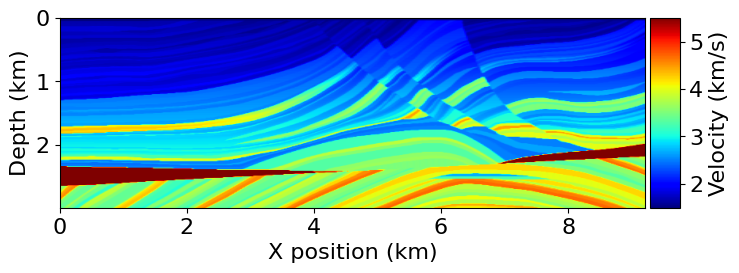

In [1]:
from examples.seismic import Model, plot_velocity
from devito import *
import numpy as np
import matplotlib as plt

nx = 738
nz = 240
nbl = 85
nshots = 604
space_order = 8
dtype = np.float32
shape = (nx, nz)
spacing = (12.5, 12.5)
origin = (0., 0.)



v = np.empty(shape, dtype=dtype)


path = "marmousi-resample-738x240.bin"
a = open(path)
v = np.fromfile(a, dtype=dtype).reshape([nx, nz])
v=v/1000
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbl=nbl, bcs="damp")

plot_velocity(model)


Operator `initdamp` ran in 0.01 s


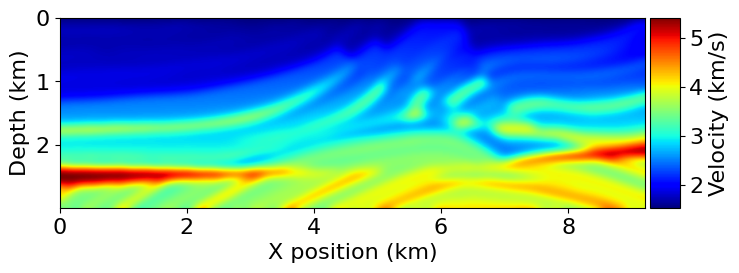

In [2]:
model0 = Model(space_order=space_order, vp=v,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)
filter_sigma = (6, 6)
gaussian_smooth(model0.vp, sigma=filter_sigma)

plot_velocity(model0)

In [3]:
from examples.seismic import TimeAxis

t0 = 0. 
tn = 5000.
dt = 0.0008
time_range = TimeAxis(start = t0, stop = tn, step = dt)



In [4]:
from examples.seismic import RickerSource

f0 = 0.030
src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 1.


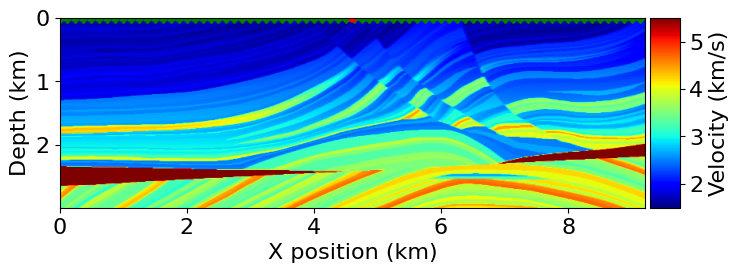

In [5]:
from examples.seismic import Receiver

rec_coordinates = np.empty((model.shape[0], 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
rec_coordinates[:, 1] = 1.

plot_velocity(model, source=src.coordinates.data,receiver=rec_coordinates[::10,:])

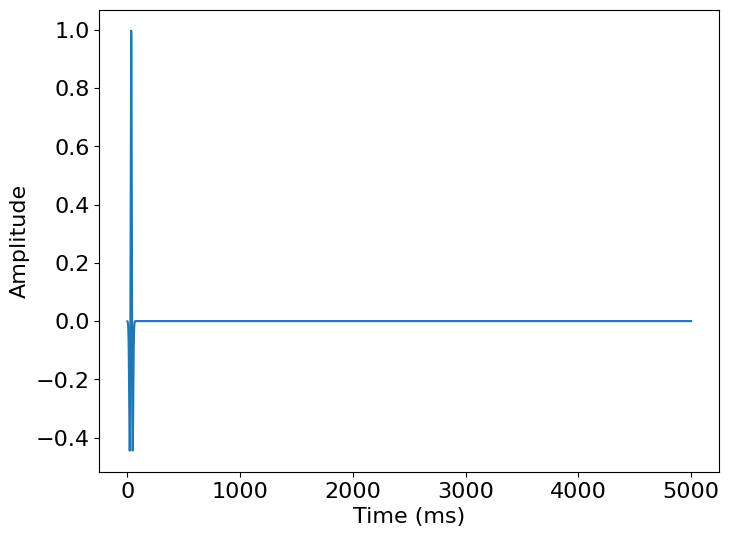

In [6]:
from examples.seismic import AcquisitionGeometry

geometry = AcquisitionGeometry(model, rec_coordinates, src.coordinates.data, t0, tn, f0=f0, src_type='Ricker')
geometry.src.show()

In [7]:
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

solver = AcousticWaveSolver(model, geometry, space_order=space_order)
true_d , _, _ = solver.forward(vp=model.vp)
smooth_d, _, _ = solver.forward(vp=model0.vp)

Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.63 s


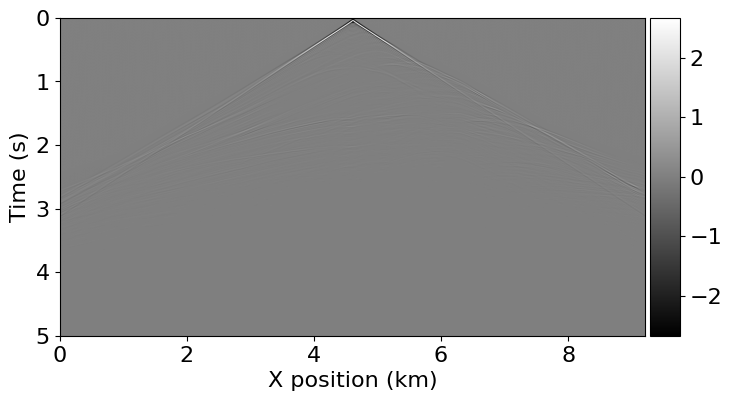

In [8]:

plot_shotrecord(true_d.data, model, t0, tn)

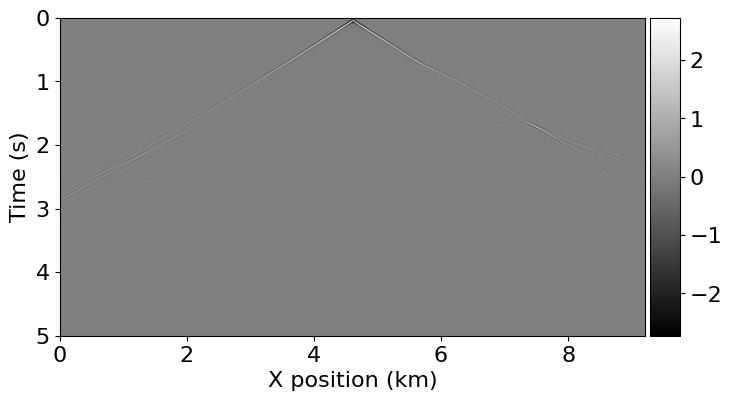

In [9]:
plot_shotrecord(smooth_d.data, model, t0, tn)

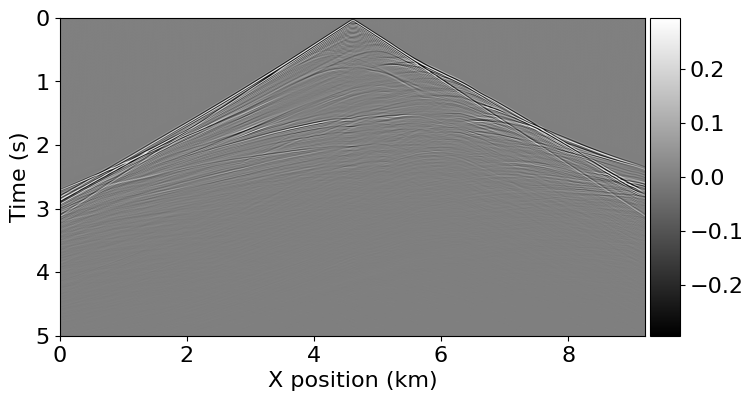

In [10]:
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

In [11]:

from examples.seismic import PointSource

def ImagingOperator(model, image):
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)
    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=space_order, save=geometry.nt)
    
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update], subs=model.spacing_map)


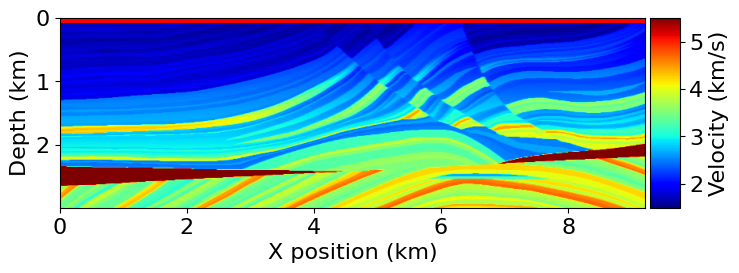

In [12]:
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.domain_size[0], num=nshots)
source_locations[:, 1] = 1

plot_velocity(model, source=source_locations)

In [13]:

image = Function(name='image', grid=model.grid,space_order=space_order)
op_imaging = ImagingOperator(model, image)

for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    geometry.src_positions[0, :] = source_locations[i, :]
    true_d, _, _ = solver.forward(vp=model.vp)
    smooth_d, u0, _ = solver.forward(vp=model0.vp, save=True)
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, residual=residual)


Imaging source 1 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.49 s


Imaging source 2 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.36 s


Imaging source 3 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.37 s


Imaging source 4 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.38 s


Imaging source 5 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.43 s


Imaging source 6 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.44 s


Imaging source 7 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.39 s


Imaging source 8 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.41 s


Imaging source 9 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.23 s
Operator `Kernel` ran in 2.62 s


Imaging source 10 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.46 s


Imaging source 11 out of 604


Operator `Forward` ran in 1.74 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.44 s


Imaging source 12 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.35 s


Imaging source 13 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.37 s


Imaging source 14 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.39 s


Imaging source 15 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.90 s
Operator `Kernel` ran in 2.93 s


Imaging source 16 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 3.22 s
Operator `Kernel` ran in 2.61 s


Imaging source 17 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.88 s


Imaging source 18 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.42 s


Imaging source 19 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.94 s


Imaging source 20 out of 604


Operator `Forward` ran in 1.75 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.46 s


Imaging source 21 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.55 s
Operator `Kernel` ran in 2.83 s


Imaging source 22 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.45 s


Imaging source 23 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.42 s


Imaging source 24 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.54 s
Operator `Kernel` ran in 3.00 s


Imaging source 25 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.24 s


Imaging source 26 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.44 s
Operator `Kernel` ran in 2.83 s


Imaging source 27 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.13 s
Operator `Kernel` ran in 2.48 s


Imaging source 28 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.47 s


Imaging source 29 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.76 s
Operator `Kernel` ran in 2.69 s


Imaging source 30 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.41 s


Imaging source 31 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.46 s


Imaging source 32 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.42 s


Imaging source 33 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.68 s


Imaging source 34 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.92 s


Imaging source 35 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.31 s
Operator `Kernel` ran in 2.76 s


Imaging source 36 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.41 s


Imaging source 37 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.73 s


Imaging source 38 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.46 s


Imaging source 39 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.46 s


Imaging source 40 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.48 s


Imaging source 41 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 3.30 s
Operator `Kernel` ran in 2.71 s


Imaging source 42 out of 604


Operator `Forward` ran in 1.79 s
Operator `Forward` ran in 2.15 s
Operator `Kernel` ran in 2.50 s


Imaging source 43 out of 604


Operator `Forward` ran in 1.81 s
Operator `Forward` ran in 2.63 s
Operator `Kernel` ran in 2.68 s


Imaging source 44 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.92 s
Operator `Kernel` ran in 2.36 s


Imaging source 45 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.61 s


Imaging source 46 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.47 s


Imaging source 47 out of 604


Operator `Forward` ran in 1.75 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.51 s


Imaging source 48 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.41 s


Imaging source 49 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.41 s


Imaging source 50 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.55 s


Imaging source 51 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.62 s


Imaging source 52 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.71 s


Imaging source 53 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.19 s


Imaging source 54 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.51 s


Imaging source 55 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.40 s


Imaging source 56 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.41 s


Imaging source 57 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 58 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.84 s


Imaging source 59 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.40 s


Imaging source 60 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.42 s


Imaging source 61 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.40 s


Imaging source 62 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.19 s


Imaging source 63 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.53 s
Operator `Kernel` ran in 2.53 s


Imaging source 64 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.43 s


Imaging source 65 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.78 s


Imaging source 66 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.39 s


Imaging source 67 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.42 s


Imaging source 68 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.41 s


Imaging source 69 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.91 s


Imaging source 70 out of 604


Operator `Forward` ran in 1.59 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.37 s


Imaging source 71 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.18 s


Imaging source 72 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.44 s


Imaging source 73 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.38 s


Imaging source 74 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.36 s


Imaging source 75 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.64 s


Imaging source 76 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.38 s


Imaging source 77 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.47 s


Imaging source 78 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.49 s


Imaging source 79 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.79 s


Imaging source 80 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.40 s
Operator `Kernel` ran in 2.89 s


Imaging source 81 out of 604


Operator `Forward` ran in 1.79 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.78 s


Imaging source 82 out of 604


Operator `Forward` ran in 1.80 s
Operator `Forward` ran in 2.15 s
Operator `Kernel` ran in 2.59 s


Imaging source 83 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.66 s


Imaging source 84 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.52 s


Imaging source 85 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.48 s


Imaging source 86 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.52 s


Imaging source 87 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.29 s
Operator `Kernel` ran in 3.26 s


Imaging source 88 out of 604


Operator `Forward` ran in 1.81 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.48 s


Imaging source 89 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.30 s


Imaging source 90 out of 604


Operator `Forward` ran in 1.75 s
Operator `Forward` ran in 1.90 s
Operator `Kernel` ran in 2.62 s


Imaging source 91 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.51 s


Imaging source 92 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.48 s


Imaging source 93 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.87 s


Imaging source 94 out of 604


Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.50 s


Imaging source 95 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.46 s


Imaging source 96 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.48 s


Imaging source 97 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.87 s


Imaging source 98 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.77 s
Operator `Kernel` ran in 2.65 s


Imaging source 99 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.88 s
Operator `Kernel` ran in 2.71 s


Imaging source 100 out of 604


Operator `Forward` ran in 1.77 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.51 s


Imaging source 101 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.19 s
Operator `Kernel` ran in 2.49 s


Imaging source 102 out of 604


Operator `Forward` ran in 1.77 s
Operator `Forward` ran in 2.15 s
Operator `Kernel` ran in 2.61 s


Imaging source 103 out of 604


Operator `Forward` ran in 1.77 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.58 s


Imaging source 104 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.46 s


Imaging source 105 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 3.12 s


Imaging source 106 out of 604


Operator `Forward` ran in 1.74 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.49 s


Imaging source 107 out of 604


Operator `Forward` ran in 1.77 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.24 s


Imaging source 108 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.91 s
Operator `Kernel` ran in 2.36 s


Imaging source 109 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.43 s


Imaging source 110 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.40 s


Imaging source 111 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.51 s


Imaging source 112 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.43 s


Imaging source 113 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.40 s


Imaging source 114 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.41 s


Imaging source 115 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.42 s


Imaging source 116 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.73 s


Imaging source 117 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.83 s
Operator `Kernel` ran in 2.39 s


Imaging source 118 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.38 s


Imaging source 119 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.72 s


Imaging source 120 out of 604


Operator `Forward` ran in 1.83 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.43 s


Imaging source 121 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.48 s


Imaging source 122 out of 604


Operator `Forward` ran in 1.77 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.52 s


Imaging source 123 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 3.13 s
Operator `Kernel` ran in 2.65 s


Imaging source 124 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.45 s


Imaging source 125 out of 604


Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 1.93 s
Operator `Kernel` ran in 2.33 s


Imaging source 126 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.43 s


Imaging source 127 out of 604


Operator `Forward` ran in 1.81 s
Operator `Forward` ran in 2.17 s
Operator `Kernel` ran in 2.54 s


Imaging source 128 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.53 s


Imaging source 129 out of 604


Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 2.15 s
Operator `Kernel` ran in 2.63 s


Imaging source 130 out of 604


Operator `Forward` ran in 1.87 s
Operator `Forward` ran in 2.78 s
Operator `Kernel` ran in 3.05 s


Imaging source 131 out of 604


Operator `Forward` ran in 1.88 s
Operator `Forward` ran in 2.17 s
Operator `Kernel` ran in 2.56 s


Imaging source 132 out of 604


Operator `Forward` ran in 1.81 s
Operator `Forward` ran in 2.17 s
Operator `Kernel` ran in 2.55 s


Imaging source 133 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.64 s


Imaging source 134 out of 604


Operator `Forward` ran in 1.84 s
Operator `Forward` ran in 1.94 s
Operator `Kernel` ran in 2.44 s


Imaging source 135 out of 604


Operator `Forward` ran in 1.82 s
Operator `Forward` ran in 2.52 s
Operator `Kernel` ran in 2.81 s


Imaging source 136 out of 604


Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 2.17 s
Operator `Kernel` ran in 2.63 s


Imaging source 137 out of 604


Operator `Forward` ran in 1.85 s
Operator `Forward` ran in 2.25 s
Operator `Kernel` ran in 3.03 s


Imaging source 138 out of 604


Operator `Forward` ran in 1.88 s
Operator `Forward` ran in 2.20 s
Operator `Kernel` ran in 2.64 s


Imaging source 139 out of 604


Operator `Forward` ran in 1.95 s
Operator `Forward` ran in 2.21 s
Operator `Kernel` ran in 2.60 s


Imaging source 140 out of 604


Operator `Forward` ran in 1.88 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.62 s


Imaging source 141 out of 604


Operator `Forward` ran in 1.84 s
Operator `Forward` ran in 3.37 s
Operator `Kernel` ran in 2.70 s


Imaging source 142 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.57 s


Imaging source 143 out of 604


Operator `Forward` ran in 1.74 s
Operator `Forward` ran in 1.88 s
Operator `Kernel` ran in 2.35 s


Imaging source 144 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 1.90 s
Operator `Kernel` ran in 2.28 s


Imaging source 145 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.40 s
Operator `Kernel` ran in 2.76 s


Imaging source 146 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.40 s


Imaging source 147 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.59 s


Imaging source 148 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.44 s


Imaging source 149 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.47 s


Imaging source 150 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.70 s


Imaging source 151 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.84 s


Imaging source 152 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.79 s


Imaging source 153 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.24 s


Imaging source 154 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.43 s


Imaging source 155 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.45 s


Imaging source 156 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.43 s


Imaging source 157 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.43 s


Imaging source 158 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.69 s


Imaging source 159 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.43 s


Imaging source 160 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.45 s


Imaging source 161 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.43 s


Imaging source 162 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.29 s


Imaging source 163 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.46 s
Operator `Kernel` ran in 2.57 s


Imaging source 164 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.46 s


Imaging source 165 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.77 s


Imaging source 166 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.45 s


Imaging source 167 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.45 s


Imaging source 168 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.42 s


Imaging source 169 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.90 s


Imaging source 170 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 171 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.29 s


Imaging source 172 out of 604


Operator `Forward` ran in 1.74 s
Operator `Forward` ran in 1.83 s
Operator `Kernel` ran in 2.59 s


Imaging source 173 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.43 s


Imaging source 174 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.42 s


Imaging source 175 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.74 s


Imaging source 176 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.44 s


Imaging source 177 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.44 s


Imaging source 178 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.46 s


Imaging source 179 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.44 s


Imaging source 180 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.37 s


Imaging source 181 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.24 s


Imaging source 182 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.52 s
Operator `Kernel` ran in 2.72 s


Imaging source 183 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.43 s


Imaging source 184 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.43 s


Imaging source 185 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.46 s


Imaging source 186 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 187 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 188 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.49 s


Imaging source 189 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.23 s


Imaging source 190 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.34 s


Imaging source 191 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.47 s


Imaging source 192 out of 604


Operator `Forward` ran in 1.75 s
Operator `Forward` ran in 2.13 s
Operator `Kernel` ran in 2.46 s


Imaging source 193 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.45 s


Imaging source 194 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.90 s
Operator `Kernel` ran in 2.75 s


Imaging source 195 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.45 s


Imaging source 196 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.45 s


Imaging source 197 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.44 s


Imaging source 198 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.23 s


Imaging source 199 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.38 s
Operator `Kernel` ran in 2.56 s


Imaging source 200 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.47 s


Imaging source 201 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.73 s


Imaging source 202 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.47 s


Imaging source 203 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.44 s


Imaging source 204 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.44 s


Imaging source 205 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.91 s


Imaging source 206 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.43 s


Imaging source 207 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.23 s


Imaging source 208 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.33 s


Imaging source 209 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.41 s


Imaging source 210 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.43 s


Imaging source 211 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.46 s


Imaging source 212 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.47 s


Imaging source 213 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.43 s


Imaging source 214 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.47 s


Imaging source 215 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.47 s


Imaging source 216 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.59 s


Imaging source 217 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.83 s
Operator `Kernel` ran in 2.34 s


Imaging source 218 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.43 s


Imaging source 219 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.65 s


Imaging source 220 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.15 s
Operator `Kernel` ran in 2.46 s


Imaging source 221 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.44 s


Imaging source 222 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.46 s


Imaging source 223 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 3.05 s
Operator `Kernel` ran in 2.62 s


Imaging source 224 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.44 s


Imaging source 225 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.87 s
Operator `Kernel` ran in 2.29 s


Imaging source 226 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.88 s
Operator `Kernel` ran in 2.21 s


Imaging source 227 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.42 s


Imaging source 228 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.47 s


Imaging source 229 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.17 s
Operator `Kernel` ran in 2.49 s


Imaging source 230 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.97 s


Imaging source 231 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 232 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.47 s


Imaging source 233 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.49 s


Imaging source 234 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 1.87 s
Operator `Kernel` ran in 2.28 s


Imaging source 235 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.72 s


Imaging source 236 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.49 s


Imaging source 237 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.57 s


Imaging source 238 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.48 s


Imaging source 239 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.48 s


Imaging source 240 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.43 s


Imaging source 241 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.85 s
Operator `Kernel` ran in 2.83 s


Imaging source 242 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.44 s


Imaging source 243 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.26 s


Imaging source 244 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.24 s


Imaging source 245 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.41 s
Operator `Kernel` ran in 2.76 s


Imaging source 246 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.46 s


Imaging source 247 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.15 s
Operator `Kernel` ran in 2.47 s


Imaging source 248 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.43 s


Imaging source 249 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.45 s


Imaging source 250 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.61 s


Imaging source 251 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.77 s


Imaging source 252 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.83 s


Imaging source 253 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.27 s


Imaging source 254 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.89 s
Operator `Kernel` ran in 2.49 s


Imaging source 255 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.46 s


Imaging source 256 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.46 s


Imaging source 257 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.45 s


Imaging source 258 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.87 s


Imaging source 259 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.43 s


Imaging source 260 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 261 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.44 s


Imaging source 262 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.21 s


Imaging source 263 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.44 s
Operator `Kernel` ran in 2.58 s


Imaging source 264 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.41 s


Imaging source 265 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.69 s


Imaging source 266 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.43 s


Imaging source 267 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 268 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 269 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.74 s


Imaging source 270 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.39 s


Imaging source 271 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.18 s


Imaging source 272 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.45 s


Imaging source 273 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.42 s


Imaging source 274 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.39 s


Imaging source 275 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.73 s


Imaging source 276 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.45 s


Imaging source 277 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.41 s


Imaging source 278 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.42 s


Imaging source 279 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.42 s


Imaging source 280 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.30 s


Imaging source 281 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.21 s


Imaging source 282 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.47 s
Operator `Kernel` ran in 2.68 s


Imaging source 283 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.42 s


Imaging source 284 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.41 s


Imaging source 285 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.40 s


Imaging source 286 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.42 s


Imaging source 287 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.40 s


Imaging source 288 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.38 s


Imaging source 289 out of 604


Operator `Forward` ran in 1.59 s
Operator `Forward` ran in 1.83 s
Operator `Kernel` ran in 2.21 s


Imaging source 290 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.87 s
Operator `Kernel` ran in 2.64 s


Imaging source 291 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 292 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.44 s


Imaging source 293 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.42 s
Operator `Kernel` ran in 2.78 s


Imaging source 294 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.39 s


Imaging source 295 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.39 s


Imaging source 296 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.39 s


Imaging source 297 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.39 s


Imaging source 298 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.20 s


Imaging source 299 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.35 s
Operator `Kernel` ran in 2.57 s


Imaging source 300 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.41 s


Imaging source 301 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.76 s


Imaging source 302 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.44 s


Imaging source 303 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.39 s


Imaging source 304 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.39 s


Imaging source 305 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.85 s


Imaging source 306 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 307 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.17 s


Imaging source 308 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.37 s


Imaging source 309 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 310 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.42 s


Imaging source 311 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.39 s


Imaging source 312 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.44 s


Imaging source 313 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.42 s


Imaging source 314 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 315 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.44 s


Imaging source 316 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.19 s


Imaging source 317 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.48 s
Operator `Kernel` ran in 2.49 s


Imaging source 318 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.39 s


Imaging source 319 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.35 s
Operator `Kernel` ran in 2.86 s


Imaging source 320 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.39 s


Imaging source 321 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.42 s


Imaging source 322 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.42 s


Imaging source 323 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 3.06 s


Imaging source 324 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.40 s


Imaging source 325 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.17 s


Imaging source 326 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.30 s


Imaging source 327 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.39 s


Imaging source 328 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.44 s


Imaging source 329 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.48 s


Imaging source 330 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.39 s


Imaging source 331 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.41 s


Imaging source 332 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.47 s


Imaging source 333 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.40 s


Imaging source 334 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.52 s


Imaging source 335 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.35 s


Imaging source 336 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.40 s


Imaging source 337 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.54 s


Imaging source 338 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.41 s


Imaging source 339 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.41 s


Imaging source 340 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.66 s


Imaging source 341 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 342 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.41 s


Imaging source 343 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.48 s
Operator `Kernel` ran in 2.49 s


Imaging source 344 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.90 s
Operator `Kernel` ran in 2.23 s


Imaging source 345 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.41 s


Imaging source 346 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.43 s
Operator `Kernel` ran in 2.67 s


Imaging source 347 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.41 s


Imaging source 348 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.39 s


Imaging source 349 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 350 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.39 s


Imaging source 351 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 352 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 3.57 s


Imaging source 353 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.62 s


Imaging source 354 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.25 s


Imaging source 355 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.17 s
Operator `Kernel` ran in 2.71 s


Imaging source 356 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.48 s


Imaging source 357 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.40 s


Imaging source 358 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.40 s


Imaging source 359 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 360 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.41 s


Imaging source 361 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.40 s


Imaging source 362 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.23 s


Imaging source 363 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.87 s
Operator `Kernel` ran in 2.27 s


Imaging source 364 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.38 s


Imaging source 365 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.13 s
Operator `Kernel` ran in 2.48 s


Imaging source 366 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.40 s


Imaging source 367 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.50 s
Operator `Kernel` ran in 2.78 s


Imaging source 368 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.39 s


Imaging source 369 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 370 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.40 s


Imaging source 371 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.17 s


Imaging source 372 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.43 s
Operator `Kernel` ran in 2.58 s


Imaging source 373 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.40 s


Imaging source 374 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.69 s


Imaging source 375 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.43 s


Imaging source 376 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.41 s


Imaging source 377 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.39 s


Imaging source 378 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.73 s


Imaging source 379 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.39 s


Imaging source 380 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.19 s


Imaging source 381 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.41 s


Imaging source 382 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.37 s


Imaging source 383 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.41 s


Imaging source 384 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.60 s


Imaging source 385 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.41 s


Imaging source 386 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.41 s


Imaging source 387 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.40 s


Imaging source 388 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.42 s


Imaging source 389 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.88 s
Operator `Kernel` ran in 2.29 s


Imaging source 390 out of 604


Operator `Forward` ran in 1.74 s
Operator `Forward` ran in 2.42 s
Operator `Kernel` ran in 2.51 s


Imaging source 391 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.44 s


Imaging source 392 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.74 s


Imaging source 393 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.45 s


Imaging source 394 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.46 s


Imaging source 395 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.48 s


Imaging source 396 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.90 s


Imaging source 397 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.46 s


Imaging source 398 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.20 s


Imaging source 399 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.89 s
Operator `Kernel` ran in 2.56 s


Imaging source 400 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 401 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.45 s


Imaging source 402 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.67 s


Imaging source 403 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.45 s


Imaging source 404 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.45 s


Imaging source 405 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.48 s


Imaging source 406 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.45 s


Imaging source 407 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.22 s


Imaging source 408 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.76 s


Imaging source 409 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.45 s


Imaging source 410 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.59 s


Imaging source 411 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.16 s
Operator `Kernel` ran in 2.46 s


Imaging source 412 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.45 s


Imaging source 413 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.45 s


Imaging source 414 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.43 s


Imaging source 415 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.64 s
Operator `Kernel` ran in 2.99 s


Imaging source 416 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.20 s


Imaging source 417 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.18 s
Operator `Kernel` ran in 2.61 s


Imaging source 418 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.43 s


Imaging source 419 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.45 s


Imaging source 420 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.68 s
Operator `Kernel` ran in 2.82 s


Imaging source 421 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.48 s


Imaging source 422 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.48 s


Imaging source 423 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.47 s


Imaging source 424 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.44 s


Imaging source 425 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.91 s
Operator `Kernel` ran in 2.28 s


Imaging source 426 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.90 s
Operator `Kernel` ran in 2.21 s


Imaging source 427 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.21 s
Operator `Kernel` ran in 2.81 s


Imaging source 428 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.36 s


Imaging source 429 out of 604


Operator `Forward` ran in 1.59 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.35 s


Imaging source 430 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.38 s


Imaging source 431 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.41 s


Imaging source 432 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.39 s


Imaging source 433 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.37 s


Imaging source 434 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.77 s
Operator `Kernel` ran in 2.19 s


Imaging source 435 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.51 s


Imaging source 436 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.37 s


Imaging source 437 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.40 s


Imaging source 438 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.92 s


Imaging source 439 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.71 s


Imaging source 440 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.40 s


Imaging source 441 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.38 s


Imaging source 442 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.39 s


Imaging source 443 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.17 s


Imaging source 444 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.51 s
Operator `Kernel` ran in 2.51 s


Imaging source 445 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.42 s


Imaging source 446 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 2.32 s
Operator `Kernel` ran in 2.76 s


Imaging source 447 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.40 s


Imaging source 448 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.20 s
Operator `Kernel` ran in 2.39 s


Imaging source 449 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.41 s


Imaging source 450 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.63 s


Imaging source 451 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.77 s


Imaging source 452 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.56 s


Imaging source 453 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.77 s
Operator `Kernel` ran in 2.16 s


Imaging source 454 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.22 s


Imaging source 455 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.96 s
Operator `Kernel` ran in 2.41 s


Imaging source 456 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.40 s


Imaging source 457 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.45 s


Imaging source 458 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.68 s


Imaging source 459 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.41 s


Imaging source 460 out of 604


Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.44 s


Imaging source 461 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.40 s


Imaging source 462 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.31 s


Imaging source 463 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.64 s


Imaging source 464 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.39 s


Imaging source 465 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.48 s


Imaging source 466 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.48 s
Operator `Kernel` ran in 2.80 s


Imaging source 467 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.44 s


Imaging source 468 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.42 s


Imaging source 469 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.44 s


Imaging source 470 out of 604


Operator `Forward` ran in 1.76 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 471 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.19 s


Imaging source 472 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.38 s
Operator `Kernel` ran in 2.59 s


Imaging source 473 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.40 s


Imaging source 474 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.64 s


Imaging source 475 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.45 s


Imaging source 476 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.45 s


Imaging source 477 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.44 s


Imaging source 478 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.79 s


Imaging source 479 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.46 s


Imaging source 480 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.22 s


Imaging source 481 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.45 s


Imaging source 482 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.41 s


Imaging source 483 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.45 s


Imaging source 484 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.66 s


Imaging source 485 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.13 s
Operator `Kernel` ran in 2.46 s


Imaging source 486 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.42 s


Imaging source 487 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.44 s


Imaging source 488 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.45 s


Imaging source 489 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.36 s


Imaging source 490 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.22 s


Imaging source 491 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.44 s
Operator `Kernel` ran in 2.68 s


Imaging source 492 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.45 s


Imaging source 493 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.42 s


Imaging source 494 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.39 s


Imaging source 495 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.41 s


Imaging source 496 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.40 s


Imaging source 497 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.41 s


Imaging source 498 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.20 s


Imaging source 499 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.23 s


Imaging source 500 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.95 s
Operator `Kernel` ran in 2.36 s


Imaging source 501 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.44 s


Imaging source 502 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.40 s


Imaging source 503 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.21 s
Operator `Kernel` ran in 2.97 s


Imaging source 504 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.42 s


Imaging source 505 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.41 s


Imaging source 506 out of 604


Operator `Forward` ran in 1.73 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.41 s


Imaging source 507 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 1.77 s
Operator `Kernel` ran in 2.20 s


Imaging source 508 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.50 s


Imaging source 509 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.87 s
Operator `Kernel` ran in 2.28 s


Imaging source 510 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.40 s


Imaging source 511 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.74 s


Imaging source 512 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.45 s


Imaging source 513 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.44 s


Imaging source 514 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.43 s


Imaging source 515 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.97 s
Operator `Kernel` ran in 2.42 s


Imaging source 516 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.84 s


Imaging source 517 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.44 s


Imaging source 518 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.25 s


Imaging source 519 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.41 s


Imaging source 520 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.39 s


Imaging source 521 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.42 s


Imaging source 522 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.40 s


Imaging source 523 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.99 s
Operator `Kernel` ran in 2.99 s


Imaging source 524 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.44 s


Imaging source 525 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.21 s


Imaging source 526 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.39 s


Imaging source 527 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.26 s


Imaging source 528 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.39 s


Imaging source 529 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.40 s


Imaging source 530 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.42 s


Imaging source 531 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.42 s


Imaging source 532 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.42 s


Imaging source 533 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.42 s


Imaging source 534 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 1.77 s
Operator `Kernel` ran in 2.20 s


Imaging source 535 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.18 s


Imaging source 536 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.58 s


Imaging source 537 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.40 s


Imaging source 538 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.39 s


Imaging source 539 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.39 s


Imaging source 540 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.45 s


Imaging source 541 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.12 s
Operator `Kernel` ran in 2.45 s


Imaging source 542 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.39 s


Imaging source 543 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.16 s


Imaging source 544 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.80 s
Operator `Kernel` ran in 2.31 s


Imaging source 545 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.25 s


Imaging source 546 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.43 s


Imaging source 547 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.56 s


Imaging source 548 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.40 s


Imaging source 549 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.40 s


Imaging source 550 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.01 s
Operator `Kernel` ran in 2.41 s


Imaging source 551 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.41 s


Imaging source 552 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.76 s


Imaging source 553 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.76 s
Operator `Kernel` ran in 2.18 s


Imaging source 554 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.50 s


Imaging source 555 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.27 s


Imaging source 556 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.48 s


Imaging source 557 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.43 s


Imaging source 558 out of 604


Operator `Forward` ran in 1.72 s
Operator `Forward` ran in 2.78 s
Operator `Kernel` ran in 2.73 s


Imaging source 559 out of 604


Operator `Forward` ran in 1.70 s
Operator `Forward` ran in 2.10 s
Operator `Kernel` ran in 2.41 s


Imaging source 560 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.03 s
Operator `Kernel` ran in 2.41 s


Imaging source 561 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.04 s
Operator `Kernel` ran in 2.43 s


Imaging source 562 out of 604


Operator `Forward` ran in 1.69 s
Operator `Forward` ran in 1.77 s
Operator `Kernel` ran in 2.18 s


Imaging source 563 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.94 s
Operator `Kernel` ran in 2.64 s


Imaging source 564 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.85 s
Operator `Kernel` ran in 2.24 s


Imaging source 565 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.41 s


Imaging source 566 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.14 s
Operator `Kernel` ran in 2.95 s


Imaging source 567 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.40 s


Imaging source 568 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.42 s


Imaging source 569 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.46 s


Imaging source 570 out of 604


Operator `Forward` ran in 1.71 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.46 s


Imaging source 571 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.85 s


Imaging source 572 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.86 s
Operator `Kernel` ran in 2.43 s


Imaging source 573 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.84 s
Operator `Kernel` ran in 2.23 s


Imaging source 574 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 2.39 s


Imaging source 575 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.40 s


Imaging source 576 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.39 s


Imaging source 577 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.42 s


Imaging source 578 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.05 s
Operator `Kernel` ran in 3.04 s


Imaging source 579 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.47 s


Imaging source 580 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 1.77 s
Operator `Kernel` ran in 2.17 s


Imaging source 581 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.79 s
Operator `Kernel` ran in 2.46 s


Imaging source 582 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.83 s
Operator `Kernel` ran in 2.30 s


Imaging source 583 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.41 s


Imaging source 584 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.48 s


Imaging source 585 out of 604


Operator `Forward` ran in 1.78 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.41 s


Imaging source 586 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.07 s
Operator `Kernel` ran in 2.43 s


Imaging source 587 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.40 s


Imaging source 588 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.02 s
Operator `Kernel` ran in 2.40 s


Imaging source 589 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 1.78 s
Operator `Kernel` ran in 2.21 s


Imaging source 590 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 2.32 s
Operator `Kernel` ran in 2.49 s


Imaging source 591 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 1.90 s
Operator `Kernel` ran in 2.28 s


Imaging source 592 out of 604


Operator `Forward` ran in 1.66 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.58 s


Imaging source 593 out of 604


Operator `Forward` ran in 1.68 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.41 s


Imaging source 594 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.40 s


Imaging source 595 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.43 s


Imaging source 596 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 2.00 s
Operator `Kernel` ran in 2.67 s


Imaging source 597 out of 604


Operator `Forward` ran in 1.60 s
Operator `Forward` ran in 1.98 s
Operator `Kernel` ran in 2.40 s


Imaging source 598 out of 604


Operator `Forward` ran in 1.61 s
Operator `Forward` ran in 1.82 s
Operator `Kernel` ran in 2.16 s


Imaging source 599 out of 604


Operator `Forward` ran in 1.62 s
Operator `Forward` ran in 1.81 s
Operator `Kernel` ran in 2.38 s


Imaging source 600 out of 604


Operator `Forward` ran in 1.65 s
Operator `Forward` ran in 1.89 s
Operator `Kernel` ran in 2.24 s


Imaging source 601 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.09 s
Operator `Kernel` ran in 2.43 s


Imaging source 602 out of 604


Operator `Forward` ran in 1.63 s
Operator `Forward` ran in 2.06 s
Operator `Kernel` ran in 2.40 s


Imaging source 603 out of 604


Operator `Forward` ran in 1.64 s
Operator `Forward` ran in 2.08 s
Operator `Kernel` ran in 2.41 s


Imaging source 604 out of 604


Operator `Forward` ran in 1.67 s
Operator `Forward` ran in 2.11 s
Operator `Kernel` ran in 2.41 s


Original data shape: (908, 409)
Clipping low values below -86732.15625 and high values above 88442.70312.


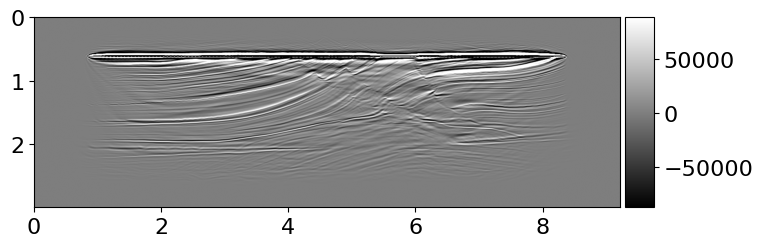

In [14]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(image.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (908, 409)
Clipping low values below -86732.15625 and high values above 88442.70312.


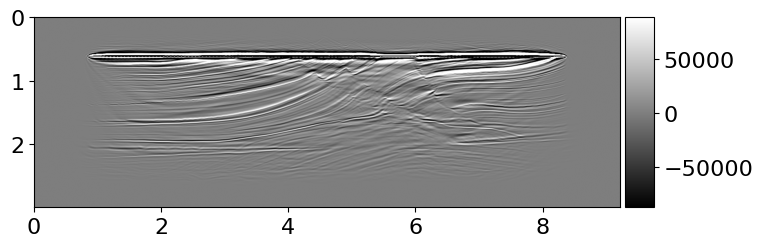

In [15]:
plot_image2(np.diff(image.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (738, 239)
Clipping low values below -86630.83594 and high values above 97405.96875.


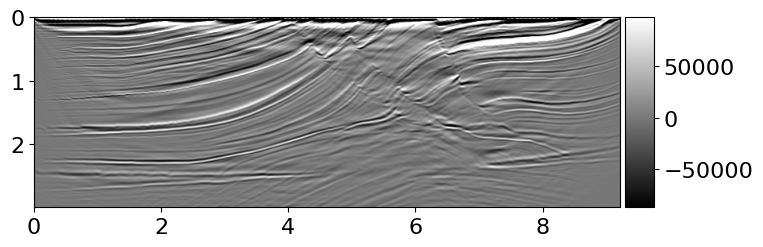

In [16]:
sliced_image = image.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image, axis=1),model,clip_percent=98,clip_low=2)


In [17]:
laplace_result = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result, image.laplace)
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000374, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Original data shape: (908, 410)
Clipping low values below -534.49573 and high values above 527.03790.


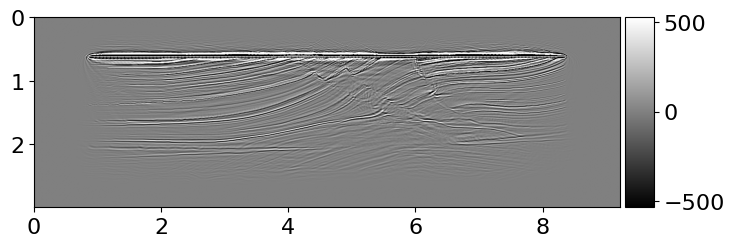

In [18]:
plot_image2(laplace_result.data,model,clip_percent=98,clip_low=2)


Original data shape: (738, 240)
Clipping low values below -568.69153 and high values above 634.25604.


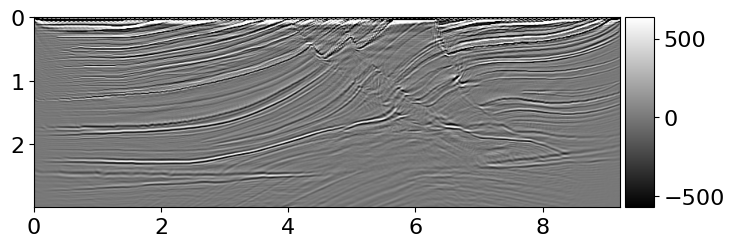

In [19]:
sliced_laplace = laplace_result.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace,model,clip_percent=98,clip_low=2)
